## Diabetes mellitus en indios PIMA

##### Se ha realizado una revisión a un estudio realizado en la década del 80 sobre la diabetes en la población de indios Pima. Se trata del desarrollo de un modelo predictivo de tipo clasificatorio binario utilizando técnicas y recursos modernos. 

##### La base de datos de 768 registros es relativamente pequeña, cuenta con varios valores nulos y valores atípicos/fuera de rango. Por tanto la estrategia de solución se ha basado en aprovechar al máximo la información existente evitando el riesgo de sobreajuste, por lo cual se han utilizado técnicas de imputación, validación cruzada, ajuste de hiperparámetros, entre otros.


##### Composición de la muestra:
*	preg: Number of times pregnant
*	plas: Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
*	Diastolic blood pressure (mm Hg)
*	skin: Triceps skin fold thickness (mm)
*	test: 2-Hour serum insulin (mu U/ml)
*	mass: Body mass index (weight in kg/(height in m)ˆ2)
*	pedi: Diabetes pedigree function
*	age: Age (years)
*	clas: Class variable (0 or 1)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import MaxAbsScaler, RobustScaler
from fancyimpute import KNN
from sklearn.feature_selection import mutual_info_classif, SelectKBest,chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV,cross_val_score
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score

C:\Users\guill\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
pima = 'D:\\Python\\Git_seguimiento\\PIMA\\pima-indians-diabetes.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
df = pd.read_csv(pima, names=names)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
skin     768 non-null int64
test     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


##### Paso preliminar:

* En la salida anterior se puede observar la presencia de valores perdidos imputados como “0”. Esto se deduce de la naturaleza de las variables independientes Xi. La única de estas variables que puede tomar el valor de cero es la variable “Preg”, dado que eventualmente una persona puede no haber tenido embarazos. Para el resto de las variables predictoras es imposible que puedan tomar valores de cero en virtud de su naturaleza. 
Debido a esta situación el primer paso a realizar fue modificar estos valores de modo de caracterizarlos como “Nan”. Este paso es importante para no sesgar la estadística descriptiva, así como la correcta imputación de nulos y el posterior desarrollo del modelo:


In [5]:
df['plas'] = df['plas'].replace(0, np.nan)
df['pres'] = df['pres'].replace(0, np.nan)
df['skin'] = df['skin'].replace(0, np.nan)
df['test'] = df['test'].replace(0, np.nan)
df['mass'] = df['mass'].replace(0, np.nan)
df['pedi'] = df['pedi'].replace(0, np.nan)
df['age'] = df['age'].replace(0, np.nan)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     763 non-null float64
pres     733 non-null float64
skin     541 non-null float64
test     394 non-null float64
mass     757 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


##### Las variables plas, pres, skin, test y mass presentan valores nulos.

In [7]:
null_values=[df.isnull().sum(),100*(df.count()/df.shape[0])]
print(null_values[1])

preg     100.000000
plas      99.348958
pres      95.442708
skin      70.442708
test      51.302083
mass      98.567708
pedi     100.000000
age      100.000000
class    100.000000
dtype: float64


##### De la información anterior, se observa que la variable con mayor cantidad de nulo es test, seguida de skin.

## Análisis univariado

### Variable dependiente:

In [8]:
df['class'].value_counts()

0    500
1    268
Name: class, dtype: int64

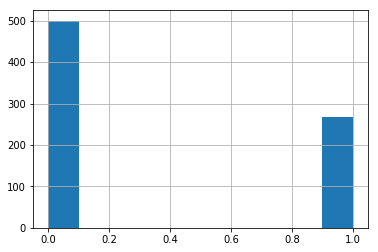

In [9]:
df['class'].hist()

##### Del resultado anterior se desprende que la variable “y” tiene desbalance. Sólo un 35% de los individuos presenta la enfermedad. Esto tendrá implicancias en el desarrollo de la estrategia de solución. Se volverá sobre este punto más adelante.

### Variables independientes

In [10]:
df_X = df.drop('class', axis=1)

##### Resumen de las variables:

In [11]:
df_X.describe()

,preg,plas,pres,skin,test,mass,pedi,age
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


##### A continuación se realizará un análisis de cada variable predictora y su relación con la variable dependiente:

##### PREG
##### Boxplot/Swarmplot:

*  Se aprecian valores extremos, pero no necesariamente son fuera de rango debido a que existe evidencia de casos de personas con elevada cantidad de embarazos. El gráfico Swarm ayuda a ver como se distribuye cada una de las muestras. El 75% de la muestra tiene una cantidad de embarazos igual o menor a 6:


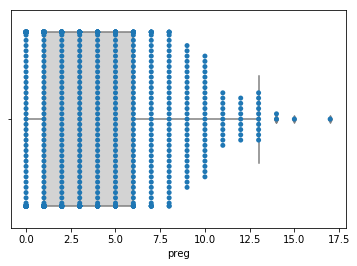

In [12]:
filtered_df = df[~np.isnan(df)]
sns.swarmplot(x=df['preg'],data=filtered_df)
sns.boxplot(x=df['preg'],data=filtered_df, color='lightgray')


*  Se puede apreciar que el grupo que presenta la enfermedad ha tenido un número de embarazos algo mayor, es decir, hay una relación entre el número de embarazos y la presencia de la diabetes:

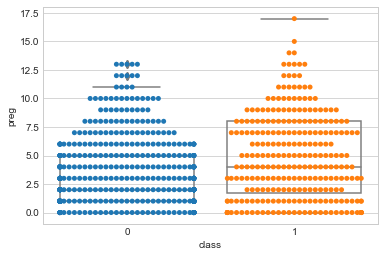

In [13]:
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df['class'], y=df['preg'],data=filtered_df)
ax = sns.boxplot(x=df['class'], y=df['preg'],data=filtered_df,
         showcaps=True, boxprops={'facecolor':'None'},
         showfliers=True, whiskerprops={'linewidth':0},color='lightgray')

plt.show()

##### PLAS
##### Boxplot/Swarmplot:
*  Llama la atención una muestra que tiene una medición de 44 mg/dl correspondiente al mínimo de la variable. La media muestral es de 121.69 mg/dl y el 75% de la muestra presenta un valor igual o menor a 141 mg/dl.


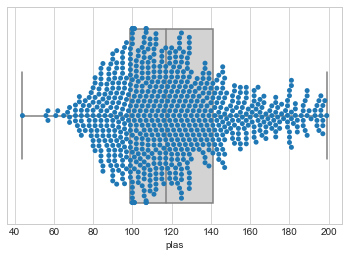

In [14]:
filtered_df = df[~np.isnan(df)]
sns.swarmplot(x=df['plas'],data=filtered_df)
sns.boxplot(x=df['plas'],data=filtered_df, color='lightgray')

*  En el siguiente gráfico se analiza la distribución de la variable respecto a las categorías de la variable dependiente. Resulta evidente la relación entre ellas. El grupo que presenta diabetes tiene un valor medio de 140 mg/dl y el otro es de aproximadamente 115 mg/dl. Esto coincide plenamente con lo esperado de la prueba de tolerancia a la glucosa ya que se espera que una persona con deterioro en la tolerancia a la glucosa tenga un índice mayor. En una prueba de tolerancia a la glucosa un valor de 200 mg/dl o más es claro signo de la enfermedad. 
De este análisis se deduce que esta es una de las variables más explicativas de la variable dependiente. Finalmente, llama la atención algunos valores extremos para el grupo que no presenta la enfermedad.


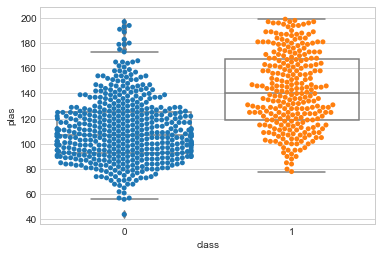

In [15]:
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df['class'], y=df['plas'],data=filtered_df)
ax = sns.boxplot(x=df['class'], y=df['plas'],data=filtered_df,
         showcaps=True, boxprops={'facecolor':'None'},
         showfliers=True, whiskerprops={'linewidth':0},color='lightgray')

plt.show()

##### PRES
##### Boxplot/Swarmplot:
*  En los siguientes gráficos se observan algunos valores fuera de rango. La mayor cantidad de individuos se concentran en un intervalo de presión diastólica de 60-80 mm Hg. 

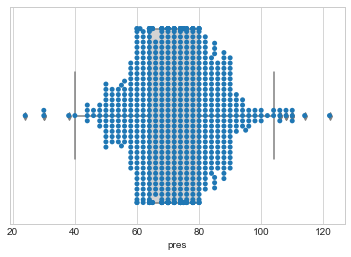

In [16]:
filtered_df = df[~np.isnan(df)]
sns.swarmplot(x=df['pres'],data=filtered_df)
sns.boxplot(x=df['pres'],data=filtered_df, color='lightgray')

*  En el siguiente gráfico se observa que los individuos positivos presentan en promedio una presión levemente superior. Esto es coherente con el hecho de que los diabéticos tienden a sufrir de presión alta.

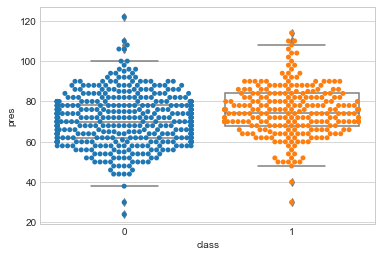

In [17]:
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df['class'], y=df['pres'],data=filtered_df)
ax = sns.boxplot(x=df['class'], y=df['pres'],data=filtered_df,
         showcaps=True, boxprops={'facecolor':'None'},
         showfliers=True, whiskerprops={'linewidth':0},color='lightgray')

plt.show()

##### SKIN
##### Boxplot/Swarmplot
*  Existen valores extremos en los siguientes gráficos:


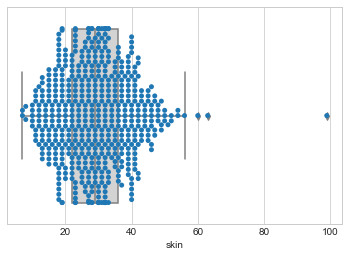

In [18]:
filtered_df = df[~np.isnan(df)]
sns.swarmplot(x=df['skin'],data=filtered_df)
sns.boxplot(x=df['skin'],data=filtered_df, color='lightgray')

*  El grupo que presenta la enfermedad tiene un valor medio mayor en la medida utilizada por el plicómetro/adipómetro (instrumento para medir los pliegues relacionados con grasa subcutánea). Según estudios, hay cierta evidencia que señala que según avanza la enfermedad  la piel es menos resistente al instrumento, lo cual evidencia una mayor presencia de grasa subcutánea, siendo un indicador de la presencia de la enfermedad. Por lo tanto, el gráfico es coherente con lo estudiado.

##### Fuente: http://www.iosrjournals.org/iosr-jdms/papers/Vol15-Issue%2011/Version-9/C1511090711.pdf

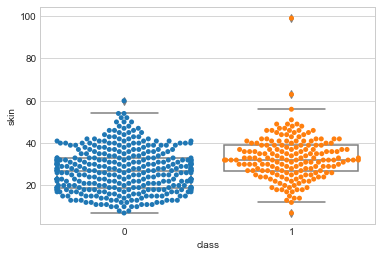

In [19]:
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df['class'], y=df['skin'],data=filtered_df)
ax = sns.boxplot(x=df['class'], y=df['skin'],data=filtered_df,
         showcaps=True, boxprops={'facecolor':'None'},
         showfliers=True, whiskerprops={'linewidth':0},color='lightgray')

plt.show()

##### TEST
##### Boxplot/Swarmplot:
*  En los siguientes gráficos se observan valores fuera de rango:


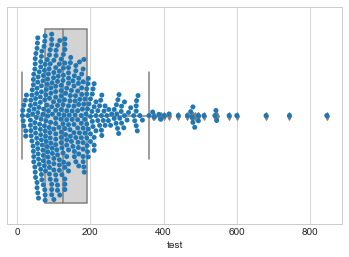

In [20]:
filtered_df = df[~np.isnan(df)]
sns.swarmplot(x=df['test'],data=filtered_df)
sns.boxplot(x=df['test'],data=filtered_df, color='lightgray')

* Es extraño ver valores tan elevados en el test, aún para pacientes diabéticos.

##### Fuente: https://www.quora.com/Is-2-hour-after-glucose-administration-test-the-same-as-2-hour-serum-insulin-mu-U-ml-test-What-is-the-normal-range-for-the-2-hour-serum-insulin-mu-U-ml-test

##### El grupo que tiene la enfermedad tiene una media superior:

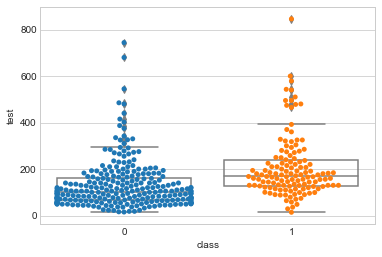

In [21]:
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df['class'], y=df['test'],data=filtered_df)
ax = sns.boxplot(x=df['class'], y=df['test'],data=filtered_df,
         showcaps=True, boxprops={'facecolor':'None'},
         showfliers=True, whiskerprops={'linewidth':0},color='lightgray')

plt.show()

##### MASS
##### Boxplot/Swarmplot:
*  En los siguientes gráficos se observan algunos valores fuera de rango
*  Existen casos documentados de individuos con índices cercanos a 70, como por ejemplo un individuo de 1.70 metros con 200 kilos de peso, pero es muy atípico y más aún en una población aborigen. Es raro ver indios gordos.


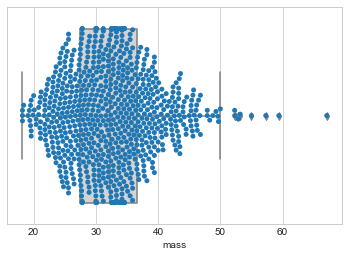

In [22]:
filtered_df = df[~np.isnan(df)]
sns.swarmplot(x=df['mass'],data=filtered_df)
sns.boxplot(x=df['mass'],data=filtered_df, color='lightgray')

*  Al observar la distribución de la muestra según la categoría, se observa que el grupo con diabetes tiene un índice de masa corporal mayor. Por otra parte, se sabe que el sobrepeso se relaciona con una mayor probabilidad de desarrollar la enfermedad, por lo que es una variable explicativa como se puede apreciar en el siguiente gráfico:
    

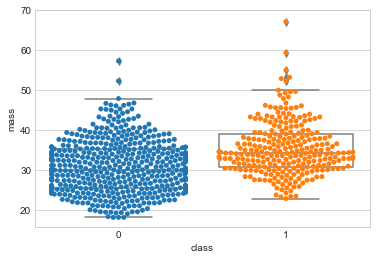

In [23]:
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df['class'], y=df['mass'],data=filtered_df)
ax = sns.boxplot(x=df['class'], y=df['mass'],data=filtered_df,
         showcaps=True, boxprops={'facecolor':'None'},
         showfliers=True, whiskerprops={'linewidth':0},color='lightgray')

plt.show()

##### PEDI
##### Boxplot/Swarmplot:
*  En los siguientes gráficos se observan algunos valores fuera de rango:


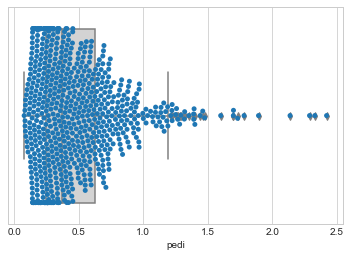

In [24]:
filtered_df = df[~np.isnan(df)]
sns.swarmplot(x=df['pedi'],data=filtered_df)
sns.boxplot(x=df['pedi'],data=filtered_df, color='lightgray')

* En el siguiente gráfico se observa una mediana levemente superior en el grupo que presenta la enfermedad. Se trata de una función empírica que debería ser revisada y testeada más en detalle. En el estudio revisado no se habla mucho sobre esta variable en términos de validación.

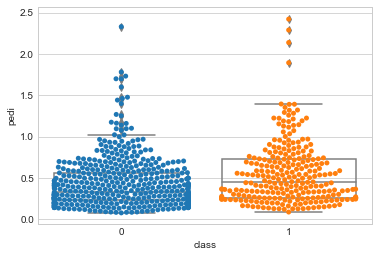

In [25]:
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df['class'], y=df['pedi'],data=filtered_df)
ax = sns.boxplot(x=df['class'], y=df['pedi'],data=filtered_df,
         showcaps=True, boxprops={'facecolor':'None'},
         showfliers=True, whiskerprops={'linewidth':0},color='lightgray')

plt.show()

##### AGE
##### Boxplot/Swarmplot:
*  El universo etáreo es joven, viéndose muy pocos individuos mayores a 60 años:


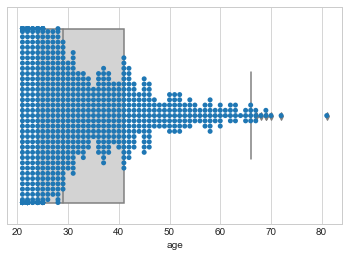

In [26]:
filtered_df = df[~np.isnan(df)]
sns.swarmplot(x=df['age'],data=filtered_df)
sns.boxplot(x=df['age'],data=filtered_df, color='lightgray')

*  El grupo que presenta diabetes tiene una mayor edad en términos de la mediana. El 75% del grupo sano es de menos de 37 años aproximadamente, mientras que el 75% del grupo con la enfermedad es menor a 45 aproximadamente: 

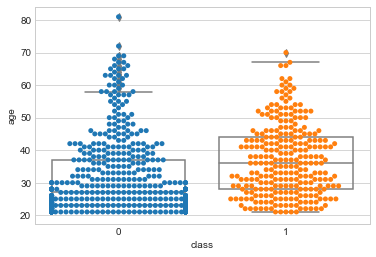

In [27]:
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df['class'], y=df['age'],data=filtered_df)
ax = sns.boxplot(x=df['class'], y=df['age'],data=filtered_df,
         showcaps=True, boxprops={'facecolor':'None'},
         showfliers=True, whiskerprops={'linewidth':0},color='lightgray')

plt.show()

## Análisis Multivariado

##### Heat Map

* Se ha utilizado un gráfico de tipo Heat Map para ver las correlaciones entre variables predictoras:


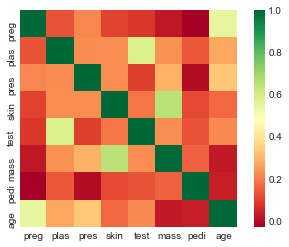

In [28]:
sns.heatmap(filtered_df.drop('class', axis=1).corr(), square=True, cmap='RdYlGn')

*  Del gráfico anterior se desprende que existe mayor correlación entre número de embarazos-edad, skin-mass, plas-test. El resto de las correlaciones son menores a 0.3 por lo que se puede inferir que no existe una gran correlación linean entre las variables predictoras, por lo que se podrían utilizar modelos que requieran dicho supuesto.

##### Pair Plot

*  Se observa que plas, pres, skin, mass tienen aparentemente una distribución normal. age, pedi, test y preg tienen distribución normal:

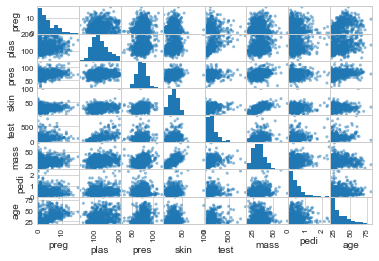

In [29]:
df_x = df.drop('class', axis=1)
pd.plotting.scatter_matrix(df_x)
plt.show()



## Preproceso

##### Outliers : Univariado

*  No todas las variables presentan distribución normal. Al no poder asumir con certeza una forma para la distribución de cada predictor, se usará el rango intercuartil (IQR) para establecer los valores fuera de rango. Típicamente se suele establecer un punto de corte de 1.5 x IQR, lo cual tiene sus inconvenientes debido a que si la distribución es normal, su naturaleza asume los valores presentes en las colas, es importante desde el punto de vista estructural. Quitar valores de los extremos de las colas puede ser erróneo. Por lo tanto, se adoptará un criterio más conservaror y se establecerá un corte a 3 x IQR, de modo tal de no afectar a las colas de una eventual distribución normal, tal como el caso de plas, pres, skin y mass. 


*  Se observaron valores poco representativos del universo muestral y tan extremos en términos fisiológicos, que finalmente se ha considerado correcto prescindir de estos. En particular, se encontraron valores IMC demasiado elevados y presiones sanguíneas que escapan a los rangos establecidos.


*  Se quitarán valores extremos de skin, test, mass, y age. Dado que en la etápa anterior se mostró que son extraños dese el punto de vista fisiológico, o muy atípicos en el caso de age. Son muy poco representativos los individuos mayores a 65 años del resto del grupo.


*  Filtro de outliers:

In [30]:
#Skin
filtered_df = df[~np.isnan(df["skin"])] # Primero se deben filtrar los nan para ocupar percentile
q25, q75 = np.percentile(filtered_df["skin"], 25), np.percentile(filtered_df["skin"], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off_tipico = iqr * 1.5   #El que se suele usar a modo de ejemplificar el tema de las colas
cut_off = iqr * 2           #El que voy a utilizar            
lower, upper = q25 - cut_off, q75 + cut_off
outliers = df[(df.skin < q25 - cut_off_tipico) | (df.skin > q75 + cut_off_tipico)]
print('Outliers:')
outliers



Percentiles: 25th=22.000, 75th=36.000, IQR=14.000
Outliers:


,preg,plas,pres,skin,test,mass,pedi,age,class
57,0,100.0,88.0,60.0,110.0,46.8,0.962,31,0
445,0,180.0,78.0,63.0,14.0,59.4,2.420,25,1
579,2,197.0,70.0,99.0,NaN,34.7,0.575,62,1


##### Si se utilizara el corte típico, estos tres registros deberían ser quitados, pero skin = 60 y 63 aún pueden ser verosímiles. Sólo skin = 99 debe ser un real outlier. El filtro a utilizar sólo quitará ese registro y será análogo el razonamiento para los casos siguientes.

In [31]:
# Filtro outliers skin
df = df.loc[~((df.skin < lower) | (df.skin > upper))]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 0 to 767
Data columns (total 9 columns):
preg     767 non-null int64
plas     762 non-null float64
pres     732 non-null float64
skin     540 non-null float64
test     394 non-null float64
mass     756 non-null float64
pedi     767 non-null float64
age      767 non-null int64
class    767 non-null int64
dtypes: float64(6), int64(3)
memory usage: 59.9 KB


In [33]:
#Test
filtered_df = df[~np.isnan(df["test"])] # Primero se deben filtrar los nan para ocupar percentile
q25, q75 = np.percentile(filtered_df["test"], 25), np.percentile(filtered_df["test"], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off = iqr * 2
lower, upper = q25 - cut_off, q75 + cut_off
outliers = df[(df.test < lower) | (df.test > upper)]
print('Outliers:')
outliers

Percentiles: 25th=76.250, 75th=190.000, IQR=113.750
Outliers:


,preg,plas,pres,skin,test,mass,pedi,age,class
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
111,8,155.0,62.0,26.0,495.0,34.0,0.543,46,1
153,1,153.0,82.0,42.0,485.0,40.6,0.687,23,0
186,8,181.0,68.0,36.0,495.0,30.1,0.615,60,1
220,0,177.0,60.0,29.0,478.0,34.6,1.072,21,1
228,4,197.0,70.0,39.0,744.0,36.7,2.329,31,0
247,0,165.0,90.0,33.0,680.0,52.3,0.427,23,0
286,5,155.0,84.0,44.0,545.0,38.7,0.619,34,0
370,3,173.0,82.0,48.0,465.0,38.4,2.137,25,1


##### Dado la grán cantidad de valores nulos de esta variable, 50%, y la presencia de muchos valores extremos (25 si el punto de corte fuera a 1.5 IQR), se optará por eliminar esta columna. 

In [34]:
df = df.drop('test', axis=1)

In [35]:
#Mass
filtered_df = df[~np.isnan(df["mass"])] # Primero se deben filtrar los nan para ocupar percentile
q25, q75 = np.percentile(filtered_df["mass"], 25), np.percentile(filtered_df["mass"], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off = iqr * 2
lower, upper = q25 - cut_off, q75 + cut_off
outliers = df[(df.mass < lower) | (df.mass > upper)]
print('Outliers:')
outliers

Percentiles: 25th=27.500, 75th=36.600, IQR=9.100
Outliers:


,preg,plas,pres,skin,mass,pedi,age,class
125,1,88.0,30.0,42.0,55.0,0.496,26,1
177,0,129.0,110.0,46.0,67.1,0.319,26,1
445,0,180.0,78.0,63.0,59.4,2.420,25,1
673,3,123.0,100.0,35.0,57.3,0.880,22,0


In [36]:
# Filtro outliers mass
df = df.loc[~((df.mass < lower) | (df.mass > upper))]

In [37]:
#Age
filtered_df = df[~np.isnan(df["age"])] # Primero se deben filtrar los nan para ocupar percentile
q25, q75 = np.percentile(filtered_df["age"], 25), np.percentile(filtered_df["age"], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off = iqr * 2
lower, upper = q25 - cut_off, q75 + cut_off
outliers = df[(df.age < lower) | (df.age > upper)]
print('Outliers:')
outliers

Percentiles: 25th=24.000, 75th=41.000, IQR=17.000
Outliers:


,preg,plas,pres,skin,mass,pedi,age,class
459,9,134.0,74.0,33.0,25.9,0.46,81,0


##### Age sin valores extremos bajo la regla aplicada. 

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 767
Data columns (total 8 columns):
preg     763 non-null int64
plas     758 non-null float64
pres     728 non-null float64
skin     536 non-null float64
mass     752 non-null float64
pedi     763 non-null float64
age      763 non-null int64
class    763 non-null int64
dtypes: float64(5), int64(3)
memory usage: 53.6 KB


##### Luego del proceso anterior, se han dejado 766 observaciones de 768 originales. 

### Imputacion de valores nulos



##### Se optará por imputar en base a vecinos más cercanos. En particular, se utilizará fancy imputer para realizarlo.Sería una mejora potencial estudiar el mejor número de vecinos a utilizar como parámetro mediante validación cruzada, pero en el presente estudio se definirá k =10. Un número alto de vecinos implicaría un modelo menos rígido, menos bías, pero mucha varianza y potencial overfitting, un número muy reducido implicaría más bias, menos varianza y el riesgo de un ajuste pobre. 

##### Fancyimpute: https://github.com/iskandr/fancyimpute

In [39]:
null_values=[df.isnull().sum(),100*(df.count()/df.shape[0])]
print(null_values[1])

preg     100.000000
plas      99.344692
pres      95.412844
skin      70.249017
mass      98.558322
pedi     100.000000
age      100.000000
class    100.000000
dtype: float64


In [40]:
col = df.columns
ind = df.index
df = pd.DataFrame(KNN(10).complete(df))
df.columns = col
df.index = ind


Imputing row 1/763 with 0 missing, elapsed time: 0.095
Imputing row 101/763 with 1 missing, elapsed time: 0.097
Imputing row 201/763 with 0 missing, elapsed time: 0.097
Imputing row 301/763 with 0 missing, elapsed time: 0.098
Imputing row 401/763 with 0 missing, elapsed time: 0.099
Imputing row 501/763 with 0 missing, elapsed time: 0.100
Imputing row 601/763 with 2 missing, elapsed time: 0.101
Imputing row 701/763 with 0 missing, elapsed time: 0.102


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 767
Data columns (total 8 columns):
preg     763 non-null float64
plas     763 non-null float64
pres     763 non-null float64
skin     763 non-null float64
mass     763 non-null float64
pedi     763 non-null float64
age      763 non-null float64
class    763 non-null float64
dtypes: float64(8)
memory usage: 53.6 KB


##### Feature Selection

* Se examinará la importancia de cada variable respecto a la respuesta y mediante chi-2. Luego se tomará una decisión sobre el conjunto de predictores definitivo a incluir en la fase de entrenamiento.

In [42]:
X = df.drop('class', axis=1)
y = df['class']

In [43]:
selector = SelectKBest(score_func=chi2,k="all")
selector.fit(X,y)
scores = selector.scores_

In [44]:
print(scores)

[ 118.68543059 1425.51126937   49.22105388  150.7865094    99.38884589
    4.91946897  180.39199831]


##### Del resultado anterior se deduce que la variable pedi tiene poca relación con la variable y. De hecho, en el paper del estudio original no se explica con grán detalle la validación de esta característica. En virtud de aquello y la poca relevancia vista por el test anterior, se eliminará del conjunto de predictores definitivo. 

##### Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/pdf/procascamc00018-0276.pdf

##### La variable pres también resultó de poca relevancia según el test. No quitará de momento y en una segunda evaluación se verá si realmente es necesario utilizarla. 

In [45]:

df =df.drop(['pedi'], axis= 1)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 767
Data columns (total 7 columns):
preg     763 non-null float64
plas     763 non-null float64
pres     763 non-null float64
skin     763 non-null float64
mass     763 non-null float64
age      763 non-null float64
class    763 non-null float64
dtypes: float64(7)
memory usage: 47.7 KB


## Prueba de algortimos por validación cruzada

##### Se realizará una prueba de varios clasificadores con el objetivo de definir el más adecuado para el caso en estudio:

In [47]:
X = df.drop('class', axis=1).values
y = df['class'].values


##### Se utilizará el Robust Scaler como paso previo debido a que utiliza el rango intercuartil para escalar, lo que lo hace adecuado considerando valores extremos y distribuciones no necesariamente normales, como en este caso.

##### Para la validación cruzada se utilizará su modalidad estratificada para tener en cuenta el desbalance de clases de la variable a predecir. El objetivo es que cada k-fold tenga una muestra representativa que considere el desbalance. Por otra parte, se ha utilizado la métrica "roc_auc" que evalúa el área bajo la curva roc. Se considera adecuado para el presente estudio, debido a que se pretende llegar a un modelo que sea capaz de predecir la enfermedad en vez de que tenga un nivel de accuracy elevedado solamente. Por lo tanto, es importante considerar un modelo con buena tasa de recall.

##### Además de algoritmos tradicionales, se han incluido ensembles de tipo boosting y bagging.

LR: 0.834614 (0.040378)
KNN: 0.802290 (0.044984)
CART: 0.672167 (0.078922)
NB: 0.822935 (0.044466)
SVC: 0.831556 (0.045744)
RF: 0.795808 (0.051463)
AB: 0.794297 (0.047193)
GB: 0.826379 (0.045183)


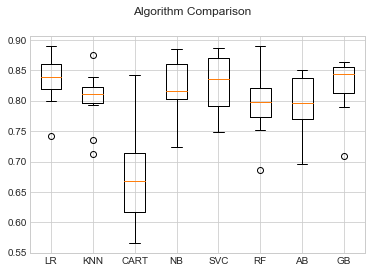

In [48]:
#modelos
models = []
models.append(('LR', LogisticRegression( )))
models.append(('KNN', KNeighborsClassifier(n_neighbors=10)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('RF' , RandomForestClassifier(random_state=25)))
models.append(('AB',  AdaBoostClassifier(random_state=7)))
models.append(('GB', GradientBoostingClassifier(random_state=7)))

# evaluacion
results = []
names = []
scoring = 'roc_auc'
sc = RobustScaler()

for name, model in models:
    steps = [('scaler', sc),('model', model)]
    pipeline = Pipeline(steps)
    skf = StratifiedKFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(pipeline, X, y, cv=skf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot comparacion
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 767
Data columns (total 7 columns):
preg     763 non-null float64
plas     763 non-null float64
pres     763 non-null float64
skin     763 non-null float64
mass     763 non-null float64
age      763 non-null float64
class    763 non-null float64
dtypes: float64(7)
memory usage: 47.7 KB


##### De los resultados anteriores se observa que SVC obtuvo un comportamiento con variabilidad aceptable,resultados acotados y buen nivel de precisión. Este será el modelo seleccionado para finalizar el estudio.

## Modelo final con ajuste de hiperparámetros y prueba en test de validación.

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

sc = RobustScaler() 
svc = SVC(probability=True)
steps = [('scaler', sc),('SVM', svc)]
pipeline = Pipeline(steps)

# GridSearch
c_values = [0.001,0.002,0.004,0.006,0.008,0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
parameters = {'SVM__C': c_values, 'SVM__kernel': kernel_values}

grid = GridSearchCV(pipeline, parameters,scoring='recall', cv=3)
grid.fit(X_train, Y_train)
print("Tuned Model Parameters: {}".format(grid.best_params_))
y_pred = grid.predict(X_test)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
y_pred_prob = grid.predict_proba(X_test)[:,1]
print("AUC: {}".format(roc_auc_score(Y_test, y_pred_prob)))

Tuned Model Parameters: {'SVM__C': 0.6, 'SVM__kernel': 'sigmoid'}
[[86 14]
 [24 29]]
             precision    recall  f1-score   support

        0.0       0.78      0.86      0.82       100
        1.0       0.67      0.55      0.60        53

avg / total       0.74      0.75      0.74       153

AUC: 0.8132075471698113


##### Comentarios finales

* En el modelo final se hizo énfasis en la tasa de recall del modelo. Dado que el modelo original se enfoca en poder predecir la enfermedad, se privilegió esta tasa con el objetivo de obtener la mejor detección de casos verdadero positivos y no el tener un nivel global de accuracy elevado (en este caso no es tan importante predecir clasificar los casos que no presentan la enfermedad con la mayor precisión). 

* La tasa de recall para el caso y=1 es del 55%, no es elevada y es producto del grán desbalance de la data de muestra. 

* La variable test pudo haber resultado bastante relevante, pero debido a la grán cantidad de nulos y valores extremos se optó por quitarla. 

* La variable pedi, construida por el equipo del paper original, se excluyó por la falta de validación en dicho estudio y el bajo nivel de importancia que se obtuvo en la etápa de selección de predictores.

* Sería interesante revisitar el estudio con una mayor cantidad de casos verdadero positivos, para comprobar si realmente es un modelo con potencial de predecir la diabetes en la población de indios Pima.